# Figure 6:  SMYLE & DPLE Global Sea Level Pressure ACC Maps
- This notebook also generates Figs. B05

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import regrid_utils as regrid

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Preprocessing:  Data I/O using Dask

### Create Dask Cluster

In [ ]:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [5]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_midmonth(ds0,'time')
    d0 = ds0[field].isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [6]:
%%time
# SMYLE-NOV PSL data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 11
chunk = {}
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 40.2 s, sys: 17.7 s, total: 57.9 s
Wall time: 1min 49s


5.308430192

In [7]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()
daskout = wait(smyle11_seas)

CPU times: user 41.4 s, sys: 984 ms, total: 42.4 s
Wall time: 44.9 s


In [8]:
%%time
# SMYLE-FEB PSL data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 2
chunk = {}
smyle02 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

CPU times: user 45.3 s, sys: 19 s, total: 1min 4s
Wall time: 1min 43s


5.308430192

In [9]:
%%time
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()
daskout = wait(smyle02_seas)

CPU times: user 44.4 s, sys: 877 ms, total: 45.2 s
Wall time: 47.2 s


In [10]:
%%time
# SMYLE-MAY PSL data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 5
chunk = {}
smyle05 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle05.nbytes/1e9 #GB

CPU times: user 48.6 s, sys: 18.6 s, total: 1min 7s
Wall time: 1min 48s


5.308430192

In [11]:
%%time
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()
daskout = wait(smyle05_seas)

CPU times: user 46.3 s, sys: 791 ms, total: 47.1 s
Wall time: 49.8 s


In [12]:
%%time
# SMYLE-AUG PSL data
# process all 20 ensemble members, all start dates from 1970-2019:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 8
chunk = {}
smyle08 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle08.nbytes/1e9 #GB

CPU times: user 47.7 s, sys: 18.6 s, total: 1min 6s
Wall time: 1min 42s


5.308430192

In [13]:
%%time
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()
daskout = wait(smyle08_seas)

CPU times: user 48.2 s, sys: 1.01 s, total: 49.2 s
Wall time: 51.9 s


In [14]:
%%time
# DPLE-NOV PSL data
# process all 40 ensemble members, all start dates from 1970-2017:
field = 'PSL'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40 
nlead = 24
inityears = np.arange(1970,2018,1)
startmonth = 11
chunk = {}
dple11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
dple11.nbytes/1e9 #GB

CPU times: user 14.6 s, sys: 2.34 s, total: 17 s
Wall time: 20 s


10.192172672

In [15]:
%%time
dple11_seas = cal.mon_to_seas_dask(dple11).persist()
daskout = wait(dple11_seas)

CPU times: user 1min 33s, sys: 2.03 s, total: 1min 35s
Wall time: 1min 43s


### Store datasets to disk for quicker processing next time (note this takes >30 minutes)

In [16]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas.to_netcdf(outdir+'DPLE11_PSL_seas.nc')
smyle11_seas.to_netcdf(outdir+'SMYLE11_PSL_seas.nc')
smyle02_seas.to_netcdf(outdir+'SMYLE02_PSL_seas.nc')
smyle05_seas.to_netcdf(outdir+'SMYLE05_PSL_seas.nc')
smyle08_seas.to_netcdf(outdir+'SMYLE08_PSL_seas.nc')

CPU times: user 14min 30s, sys: 19.6 s, total: 14min 50s
Wall time: 34min 41s


In [5]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
dple11_seas = xr.open_dataset(outdir+'DPLE11_PSL_seas.nc')
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_PSL_seas.nc')
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_PSL_seas.nc')
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_PSL_seas.nc')
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_PSL_seas.nc')

### Regrid Hindcast data

In [17]:
## Define 5x5 destgrid
destgrid = xr.Dataset({'lat':np.arange(-90,95,5),'lon':np.arange(0,360,5)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units':'degrees_north','long_name':'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units':'degrees_east','long_name':'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)

In [18]:
dple11_seas = regrid.add_grid_bounds(dple11_seas)
smyle11_seas = regrid.add_grid_bounds(smyle11_seas)
smyle02_seas = regrid.add_grid_bounds(smyle02_seas)
smyle05_seas = regrid.add_grid_bounds(smyle05_seas)
smyle08_seas = regrid.add_grid_bounds(smyle08_seas)

In [19]:
## Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(dple11_seas, destgrid, 'conservative', periodic=True)

In [21]:
%%time
dple11_da = regrid_cam1deg(dple11_seas.PSL)

CPU times: user 2.22 s, sys: 23.4 ms, total: 2.24 s
Wall time: 2.74 s


In [22]:
%%time
smyle11_da = regrid_cam1deg(smyle11_seas.PSL)
smyle02_da = regrid_cam1deg(smyle02_seas.PSL)
smyle05_da = regrid_cam1deg(smyle05_seas.PSL)
smyle08_da = regrid_cam1deg(smyle08_seas.PSL)

CPU times: user 18.5 ms, sys: 1.97 ms, total: 20.5 ms
Wall time: 20.5 ms


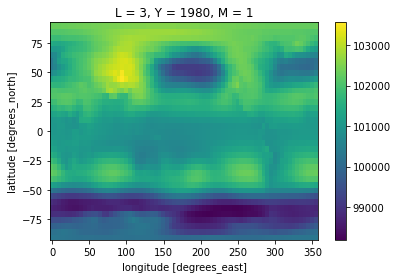

In [23]:
dple11_da.isel(Y=10,L=0,M=0).plot();

### Get SLP OBS

In [24]:
# ERA5  (already on CAM grid)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_era5 = xr.open_dataset(obs_dir+'mon/SLP/SLP_ERA5_oncamgrid_1950_2020.nc',decode_times=False)
era5_montime_vals = [cftime.DatetimeNoLeap(1950+year, 1+month, 15) for year in range(71) for month in range(12)]
ds_era5['time'] = era5_montime_vals
ds_era5 = ds_era5.sel(time=slice("1960","2020"))

In [25]:
ds_era5

<xarray.Dataset>
Dimensions:  (time: 732, n_s: 221184, lon: 288, lat: 192)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) object 1960-01-15 00:00:00 ... 2020-12-15 00:00:00
Dimensions without coordinates: n_s
Data variables:
    S        (time, n_s) float64 ...
    col      (time, n_s) float64 ...
    row      (time, n_s) float64 ...
    slp      (time, lat, lon) float64 ...

### Compute OBS seasonal averages as simple rolling mean

In [26]:
era5_psl_seas = ds_era5.slp.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all').rename('PSL')

In [27]:
era5_psl_seas = regrid.add_grid_bounds(era5_psl_seas.to_dataset())

In [28]:
era5_psl_seas['lat'] = era5_psl_seas['lat'].assign_attrs({'long_name':'latitude'})
era5_psl_seas['lon'] = era5_psl_seas['lon'].assign_attrs({'long_name':'longitude'})

### Regrid OBS

In [29]:
%%time
regrid_era5 = xe.Regridder(era5_psl_seas, destgrid, 'conservative', periodic=True)
era5_psl_seas_rg = regrid_era5(era5_psl_seas.PSL,skipna=True, na_thres=0.6)

CPU times: user 3.43 s, sys: 219 ms, total: 3.65 s
Wall time: 3.93 s


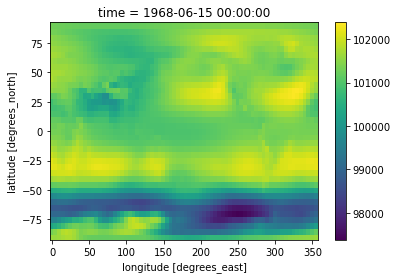

In [30]:
era5_psl_seas_rg.isel(time=100).plot()

In [31]:
era5_psl_seas_rg.time

<xarray.DataArray 'time' (time: 730)>
array([cftime.DatetimeNoLeap(1960, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 3, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 4, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2020, 9, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 11, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1960-02-15 00:00:00 ... 2020-11-15 00:00:00

In [34]:
obs = era5_psl_seas_rg

# Skill Analysis

In [32]:
%%time
smyle11_time = smyle11_seas.time.load()
smyle02_time = smyle02_seas.time.load()
smyle05_time = smyle05_seas.time.load()
smyle08_time = smyle08_seas.time.load()
dple11_time = dple11_seas.time.load()

CPU times: user 574 µs, sys: 0 ns, total: 574 µs
Wall time: 578 µs


In [33]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1972
climy1 = 2017
smyle11_anom,smyle11_clim = stats.remove_drift(smyle11_da,smyle11_time,climy0,climy1)
dple11_anom,dple11_clim = stats.remove_drift(dple11_da,dple11_time,climy0,climy1)
smyle02_anom,smyle02_clim = stats.remove_drift(smyle02_da,smyle02_time,climy0,climy1)
smyle05_anom,smyle05_clim = stats.remove_drift(smyle05_da,smyle05_time,climy0,climy1)
smyle08_anom,smyle08_clim = stats.remove_drift(smyle08_da,smyle08_time,climy0,climy1)

CPU times: user 337 ms, sys: 5.89 ms, total: 343 ms
Wall time: 358 ms


In [36]:
%%time
smyle11_anom = smyle11_anom.load()
smyle02_anom = smyle02_anom.load()
smyle05_anom = smyle05_anom.load()
smyle08_anom = smyle08_anom.load()
dple11_anom = dple11_anom.load()

CPU times: user 1min 49s, sys: 3.93 s, total: 1min 53s
Wall time: 2min 2s


In [37]:
%%time
smyle11_skill = stats.compute_skill_seasonal(smyle11_anom,smyle11_time,obs,str(climy0),str(climy1),1,8,resamp=0,detrend=False)
smyle02_skill = stats.compute_skill_seasonal(smyle02_anom,smyle02_time,obs,str(climy0),str(climy1),1,8,resamp=0,detrend=False)
smyle05_skill = stats.compute_skill_seasonal(smyle05_anom,smyle05_time,obs,str(climy0),str(climy1),1,8,resamp=0,detrend=False)
smyle08_skill = stats.compute_skill_seasonal(smyle08_anom,smyle08_time,obs,str(climy0),str(climy1),1,8,resamp=0,detrend=False)

CPU times: user 3.93 s, sys: 112 ms, total: 4.04 s
Wall time: 4.61 s


### Compute resampled (20-member) DPLE Skill

In [38]:
import xskillscore as xs

In [39]:
%%time
iterations = 100
ens_size = 20
dple11_anom_resamp = xs.resample_iterations(dple11_anom.chunk(), iterations, 'M', dim_max=ens_size).persist()

CPU times: user 790 ms, sys: 1.93 ms, total: 792 ms
Wall time: 941 ms


In [42]:
%%time
dple11_skill = stats.compute_resampskill_seasonal(dple11_anom_resamp,dple11_seas.time,obs,str(climy0),str(climy1),1,8,detrend=False,resamp=0,mean=False).load()

CPU times: user 1min 38s, sys: 1.91 s, total: 1min 40s
Wall time: 1min 46s


In [43]:
# Zero out ACC where insignificant
siglvl = 0.1
dple11_meanskill = dple11_skill.mean('iteration')
dple11_meanskill['corr'] = dple11_meanskill.corr.where(dple11_meanskill.pval<siglvl)
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 3.77 s, sys: 65.6 ms, total: 3.83 s
Wall time: 4.38 s


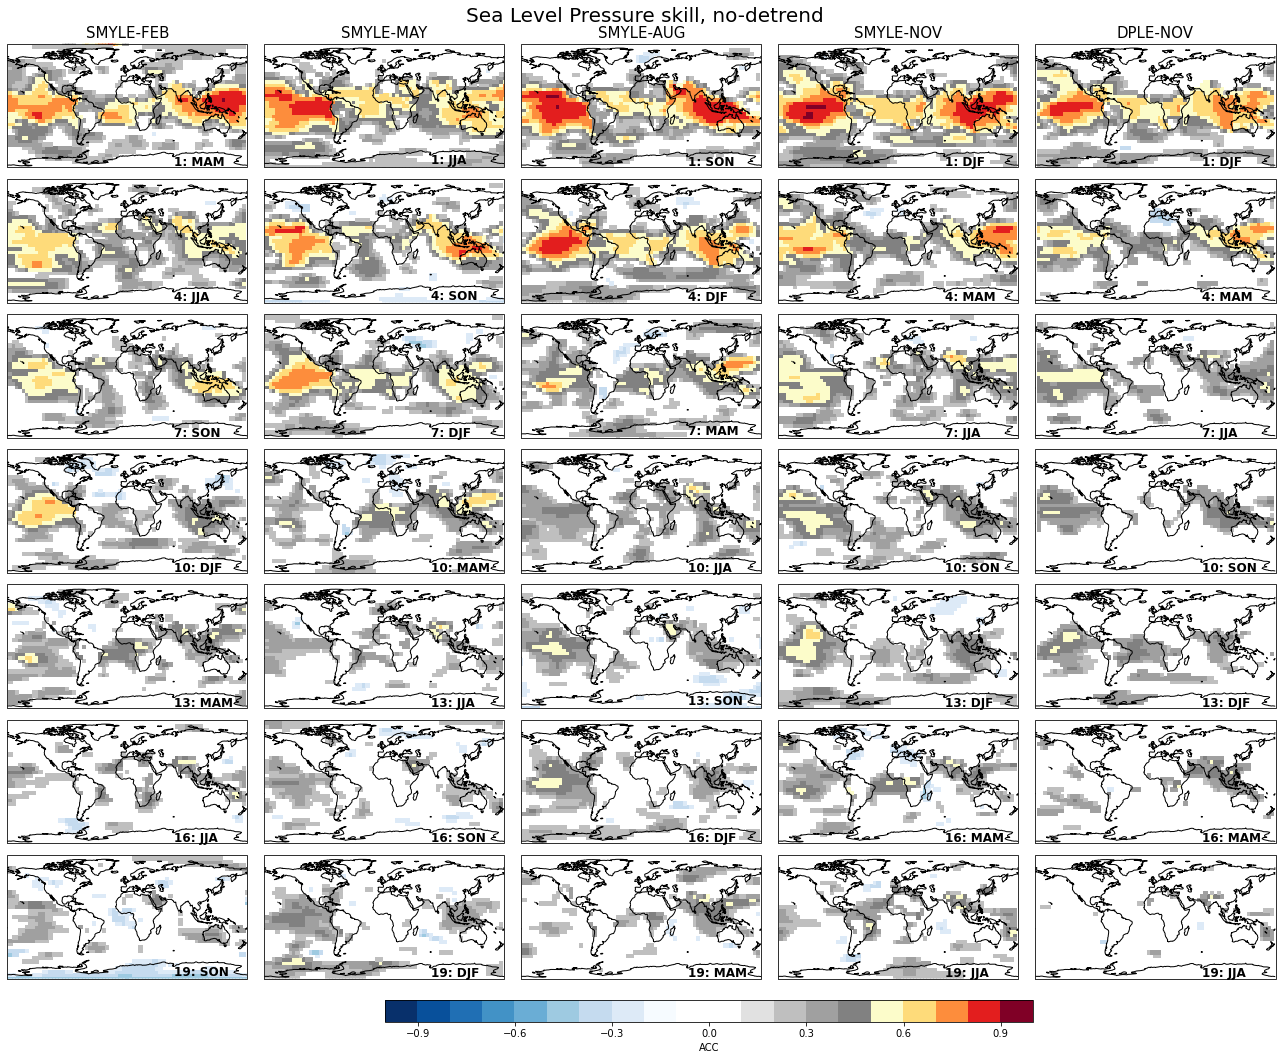

In [44]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']

ltime = smyle11_skill.L.values
seas11dict = {1:'DJF',4:'MAM',7:'JJA',10:'SON',13:'DJF',16:'MAM',19:'JJA'}
seas02dict = {1:'MAM',4:'JJA',7:'SON',10:'DJF',13:'MAM',16:'JJA',19:'SON'}
seas05dict = {1:'JJA',4:'SON',7:'DJF',10:'MAM',13:'JJA',16:'SON',19:'DJF'}
seas08dict = {1:'SON',4:'DJF',7:'MAM',10:'JJA',13:'SON',16:'DJF',19:'MAM'}
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(ltime[i])+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas02dict[ltime[i]]
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas05dict[ltime[i]]
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas08dict[ltime[i]]
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas11dict[ltime[i]]
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_meanskill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas11dict[ltime[i]]
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Sea Level Pressure skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('fB05.png')

### Use Linear Detrending

In [45]:
%%time
smyle11_skill = stats.compute_skill_seasonal(smyle11_anom,smyle11_time,obs,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle02_skill = stats.compute_skill_seasonal(smyle02_anom,smyle02_time,obs,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle05_skill = stats.compute_skill_seasonal(smyle05_anom,smyle05_time,obs,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle08_skill = stats.compute_skill_seasonal(smyle08_anom,smyle08_time,obs,str(climy0),str(climy1),1,8,resamp=0,detrend=True)

CPU times: user 10.5 s, sys: 295 ms, total: 10.8 s
Wall time: 11.8 s


In [46]:
%%time
dple11_skill = stats.compute_resampskill_seasonal(dple11_anom_resamp,dple11_seas.time,obs,str(climy0),str(climy1),1,8,detrend=True,resamp=0,mean=False).load()

CPU times: user 3min 29s, sys: 6.31 s, total: 3min 35s
Wall time: 3min 50s


In [47]:
# Zero out ACC where insignificant
siglvl = 0.1
dple11_meanskill = dple11_skill.mean('iteration')
dple11_meanskill['corr'] = dple11_meanskill.corr.where(dple11_meanskill.pval<siglvl)
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 4.58 s, sys: 162 ms, total: 4.74 s
Wall time: 4.98 s


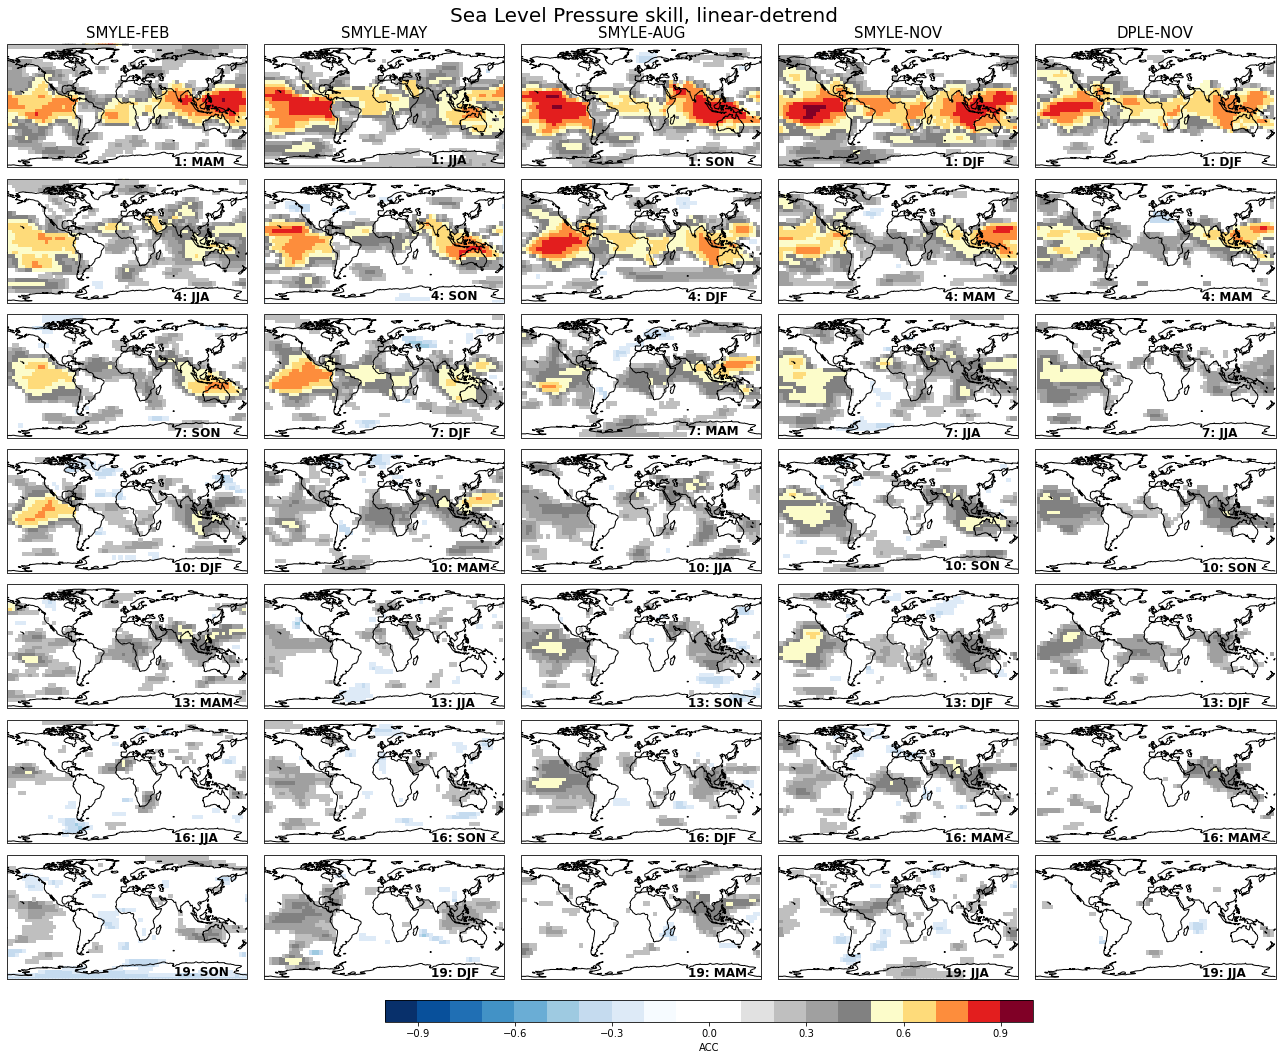

In [48]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']

ltime = smyle11_skill.L.values
seas11dict = {1:'DJF',4:'MAM',7:'JJA',10:'SON',13:'DJF',16:'MAM',19:'JJA'}
seas02dict = {1:'MAM',4:'JJA',7:'SON',10:'DJF',13:'MAM',16:'JJA',19:'SON'}
seas05dict = {1:'JJA',4:'SON',7:'DJF',10:'MAM',13:'JJA',16:'SON',19:'DJF'}
seas08dict = {1:'SON',4:'DJF',7:'MAM',10:'JJA',13:'SON',16:'DJF',19:'MAM'}
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(ltime[i])+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas02dict[ltime[i]]
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas05dict[ltime[i]]
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas08dict[ltime[i]]
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas11dict[ltime[i]]
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_meanskill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas11dict[ltime[i]]
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Sea Level Pressure skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('f06.png')

### Test significance of SMYLE11 vs DPLE11, accounting for uncertainty associated with finite ensemble size

In [49]:
%%time
# recompute skill without pvalue masking and ensuring SMYLE11 verification window matches that for DPLE11
smyle11_skill = stats.compute_skill_seasonal(smyle11_anom.sel(Y=dple11_anom.Y),smyle11_time.sel(Y=dple11_anom.Y),obs,str(climy0),str(climy1),1,8,resamp=0,detrend=True)

CPU times: user 2.87 s, sys: 186 ms, total: 3.05 s
Wall time: 3.23 s


In [50]:
## Compute p-values for SMYLE scores exceeding DPLE :
accpval = (dple11_skill.corr > smyle11_skill.corr).sum('iteration')/dple11_skill['iteration'].size

In [51]:
lon2d,lat2d = np.meshgrid(destgrid.lon, destgrid.lat)

CPU times: user 3.82 s, sys: 112 ms, total: 3.94 s
Wall time: 4.26 s


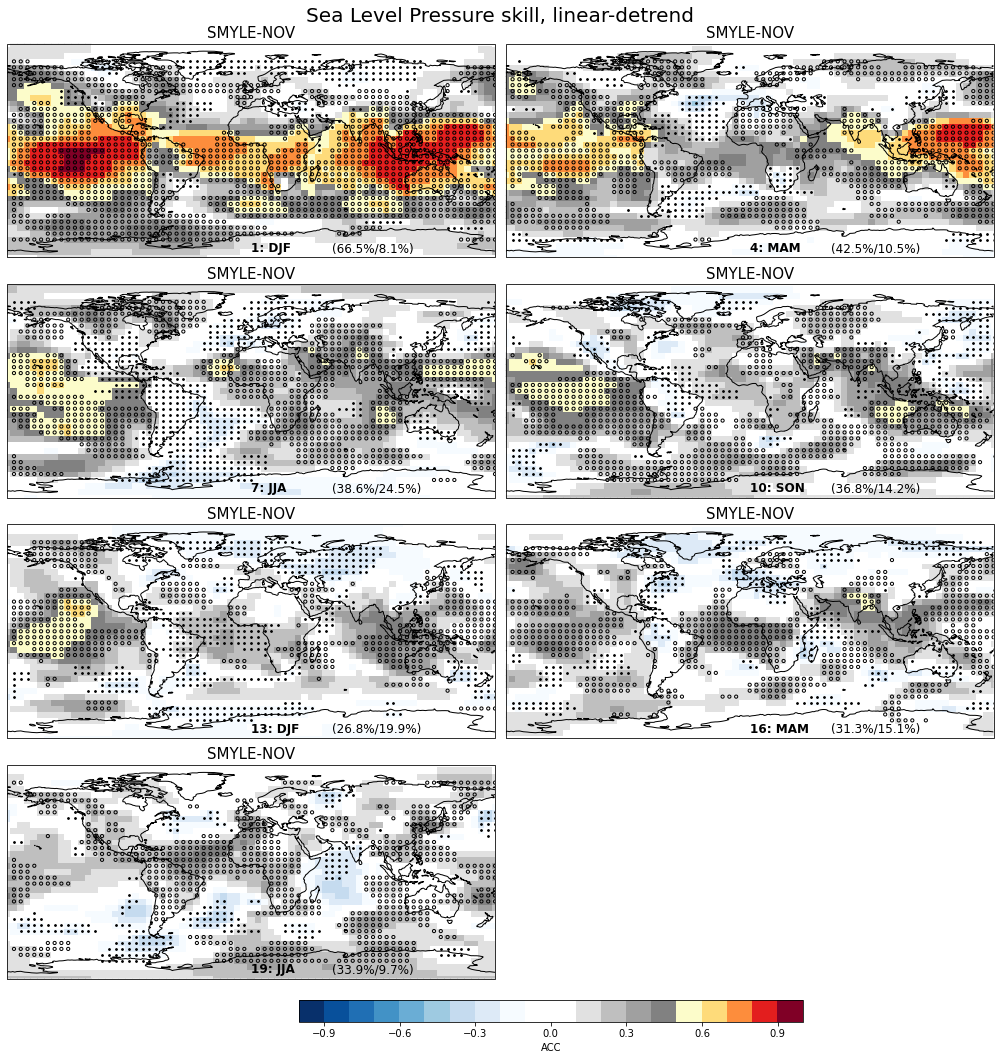

In [52]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(14,15))
nrows=4
ncols=2

proj = ccrs.PlateCarree()
colstr = 'SMYLE-NOV'

ltime = smyle11_skill.L.values
seas11dict = {1:'DJF',4:'MAM',7:'JJA',10:'SON',13:'DJF',16:'MAM',19:'JJA'}

lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
latlim = 80
symclr = 'black'

for i in range(7):
    leadstr = str(ltime[i])+': '  
    ax,cntr = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                    ci,cmin,cmax,colstr,nrows,ncols,i+1,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas11dict[ltime[i]]
    ax.text(0.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    tmp = xr.where(~smyle11_skill.corr.isel(L=i).isnull(),accpval.isel(L=i),np.nan)
    tmplon = np.where(tmp<siglvl,lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
    tmplat = np.where(tmp<siglvl,lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
    tmparea = np.where(tmp<siglvl,destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
    nbetter = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
    ax.scatter(tmplon,tmplat,facecolor='none', edgecolor=symclr,s=10,zorder=10)
    tmplon = np.where(tmp>(1-siglvl),lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
    tmplat = np.where(tmp>(1-siglvl),lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
    tmparea = np.where(tmp>(1-siglvl),destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
    nworse = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
    ax.scatter(tmplon,tmplat,facecolor=symclr, edgecolor=symclr,s=3,zorder=10)
    ax.text(60.,-85,"({0:3.1f}%/{1:3.1f}%)".format(nbetter*100,nworse*100),fontsize=fsize)


fig.suptitle('Sea Level Pressure skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr, cax=cbar_ax, label='ACC', orientation='horizontal')
plt.savefig('fB06.png')

In [53]:
smyle11_skilldiff = smyle11_skill - dple11_skill.mean('iteration')

CPU times: user 3.75 s, sys: 107 ms, total: 3.85 s
Wall time: 4.21 s


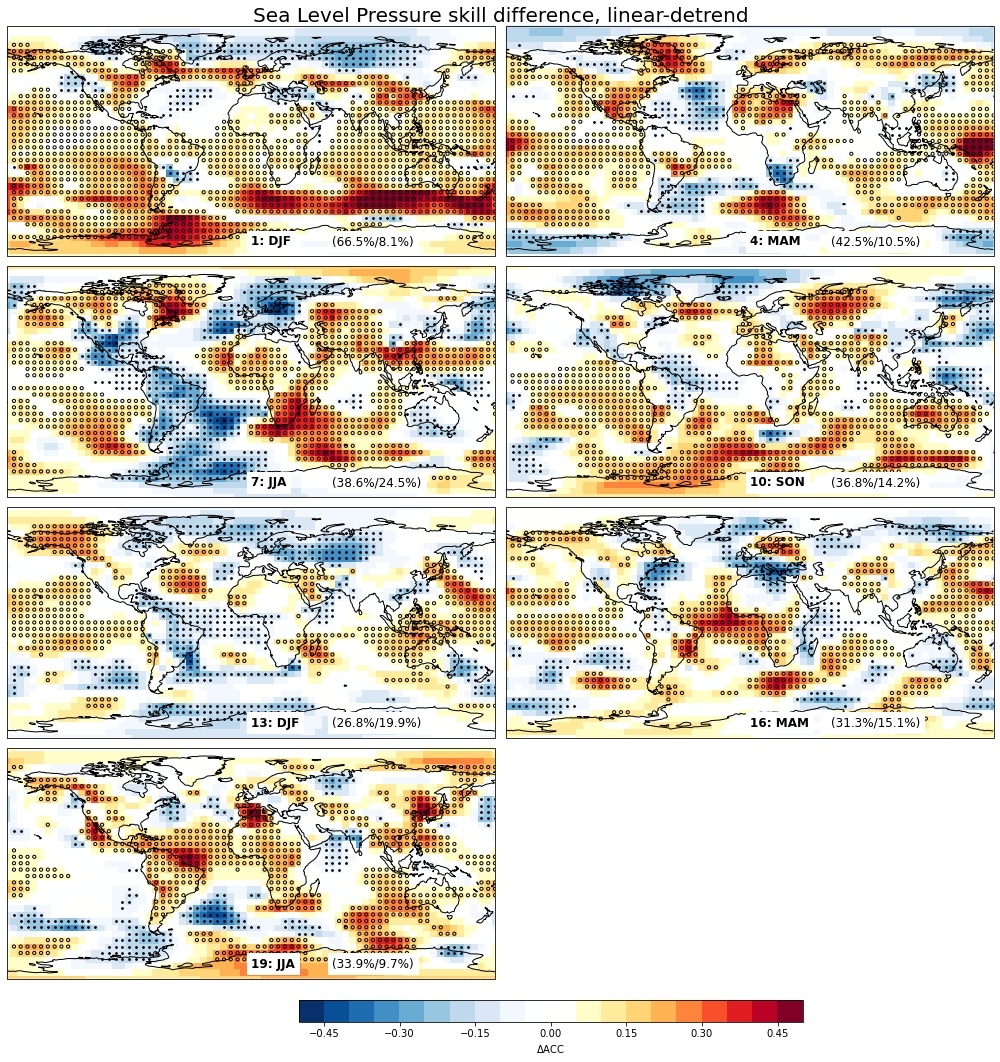

In [54]:
%%time
ci = 0.05
cmin = -0.5
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(14,15))
nrows=4
ncols=2

proj = ccrs.PlateCarree()
colstr = ''

ltime = smyle11_skill.L.values
seas11dict = {1:'DJF',4:'MAM',7:'JJA',10:'SON',13:'DJF',16:'MAM',19:'JJA'}

lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red"
coff = 0.5
siglvl = 0.1
latlim = 80
symclr = 'black'

for i in range(7):
    leadstr = str(ltime[i])+': '  
    ax,cntr = maps.map_pcolor_global_subplot(fig, smyle11_skilldiff.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                    ci,cmin,cmax,colstr,nrows,ncols,i+1,proj,cmap=cmap,cutoff=coff)
    ldstr = leadstr + seas11dict[ltime[i]]
    ax.text(0.,-81,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white',zorder=10)
    tmp = xr.where(~smyle11_skill.corr.isel(L=i).isnull(),accpval.isel(L=i),np.nan)
    tmplon = np.where(tmp<siglvl,lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
    tmplat = np.where(tmp<siglvl,lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
    tmparea = np.where(tmp<siglvl,destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
    nbetter = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
    ax.scatter(tmplon,tmplat,facecolor='none', edgecolor=symclr,s=10,zorder=10)
    tmplon = np.where(tmp>(1-siglvl),lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
    tmplat = np.where(tmp>(1-siglvl),lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
    tmparea = np.where(tmp>(1-siglvl),destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
    nworse = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
    ax.scatter(tmplon,tmplat,facecolor=symclr, edgecolor=symclr,s=3,zorder=10)
    ax.text(60.,-81,"({0:3.1f}%/{1:3.1f}%)".format(nbetter*100,nworse*100),fontsize=fsize,backgroundcolor='white',zorder=10)


fig.suptitle('Sea Level Pressure skill difference, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr, cax=cbar_ax, label=r'${\Delta}$ACC', orientation='horizontal')
plt.savefig('fB06.png')